# Hands-on Image Processing with Python

## Chapter 3: Convolution and Frequency domain Filtering
**Author: Sandipan Dey**

### Convolution and Frequency Domain Filtering

In this chapter we will continue with 2D convolution and **understand how convolution can be done faster in the frequency domain** (with **basic concepts of the convolution theorem**). We will see the **basic differences between correlation and convolution** with an example on an image. We will also describe **an example from SciPy** that will show **how to find the location of specific patterns** in an image with **a template image** using **cross-correlationtion** using kernels, such as **box-kernel or Gaussian kernel**) in the frequency domain, such as  **high-pass, low-pass, band-pass, and band-stop filters, ** and how to implement them with Python libraries by using examples. We shall demonstrate with examples how some **filters can be used for image denoising** (for example, the **band-reject or notch filters** to **remove periodic noise** from an image, or **the inverse or Wiener filters to deblur an image** that's **blurred with a Gaussian / motion-blur kernel**).

The topics to be covered in this chapter are as follows:

1. Convolution theorem and frequency domain Gaussian blur
2. Filtering in the frequency domain (with the SciPy ndimage module and scikit-image)

<p>Convolution theorem and frequency domain Gaussian blur
Filtering in the frequency domain (with the SciPy ndimage module and scikit-image)</p>

- Convolution theorem and frequency domain Gaussian blur
- Filtering in the frequency domain (with the SciPy ndimage module and scikit-image)

**Convolution theorem and frequency domain Gaussian blur**
<p>In this section, we will see more applications of convolution on images using Python modules such as scipy signal and ndimage. Let's start with convolution theorem and see how the convolution operation becomes easier in the frequency domain.</p>

**Application of the convolution theorem**
<p>The convolution theorem says that convolution in an image domain is equivalent to a simple multiplication in the frequency domain:</p>
<img src="../images/ch-3-1.png" >
<p>Following diagram shows the application of fourier transforms:</p>
<img src="../images/ch-3-2.png" >
<p>The next diagram shows the basic steps in frequency domain filtering. We have the original image, F, and a kernel (a mask or a degradation/enhancement function) as input. First, both input items need to be converted into the frequency domain with DFT, and then the convolution needs to be applied, which by convolution theorem is just an (element-wise) multiplication. This outputs the convolved image in the frequency domain, on which we need to apply IDFT to obtain the reconstructed image (with some degradation or enhancement on the original image):</p>
<img src="../images/ch-3-3.png" >

**Import libraries**

In [7]:
#pip freeze
%matplotlib inline 
from PIL import Image
from skimage.io import imread, imshow, show
import scipy.fftpack as fp
from scipy import ndimage, misc, signal
from scipy.stats import signaltonoise
from skimage import data, img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale
import matplotlib.pylab as pylab
import numpy as np
import numpy.fft
import timeit

**some note**

In [8]:
# import sys
# print(sys.version)
# from platform import python_version
# print(python_version())
# #!conda install scipy=0.19.1
# import scipy
# scipy.__version__
#!pip freeze

### Frequency domain Gaussian blur filter with numpy fft

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


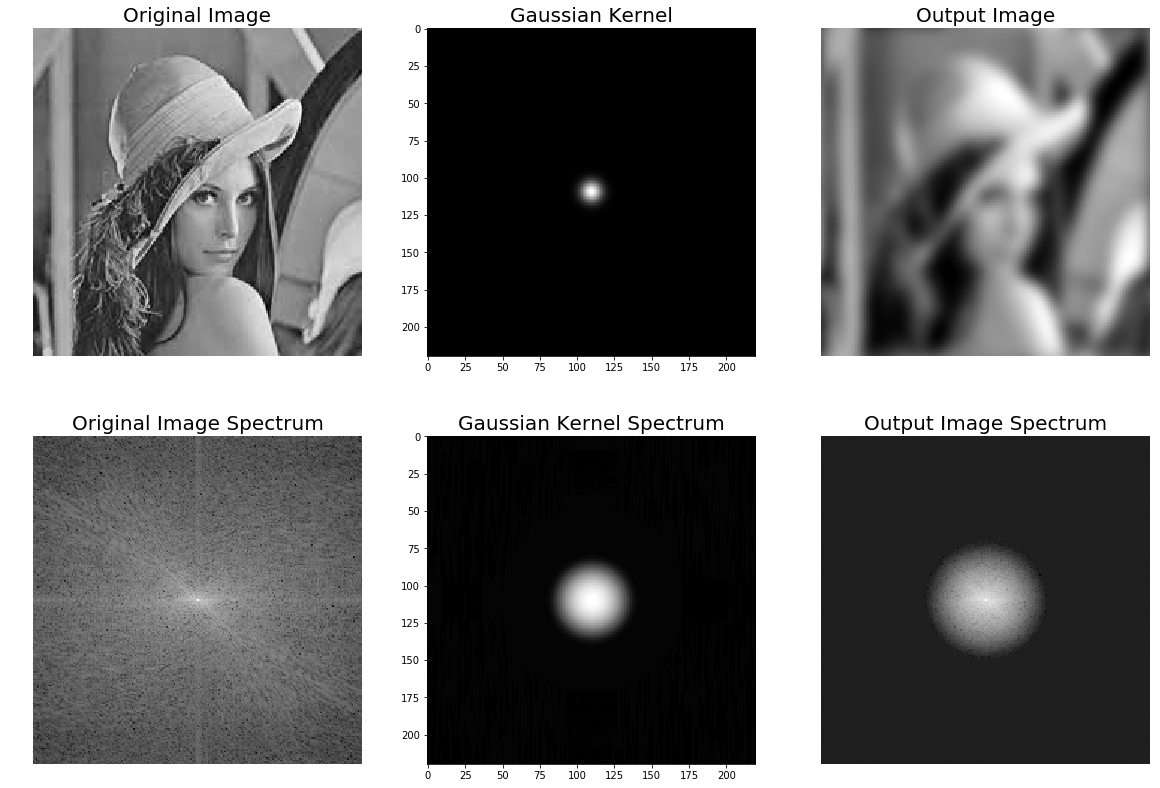

In [9]:
#please try to understand detail operations of each statement
#this is not an easy job to some of us

pylab.figure(figsize=(20,15))
pylab.gray() # show the filtered result in grayscale
im = np.mean(imread('../images/lena.jpg'), axis=2)
#average the 3 colors planes
gauss_kernel = np.outer(signal.gaussian(im.shape[0], 5), signal.gaussian(im.shape[1], 5))
#fabricate a gaussian kernal
#to this statement is preprocessing phase

freq = fp.fft2(im) #the fft operation
assert(freq.shape == gauss_kernel.shape)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel)) # arrage output image
convolved = freq*freq_kernel # by the convolution theorem, simply multiply in the frequency domain
im1 = fp.ifft2(convolved).real
#
pylab.subplot(2,3,1), pylab.imshow(im), pylab.title('Original Image',
size=20), pylab.axis('off')
pylab.subplot(2,3,2), pylab.imshow(gauss_kernel), pylab.title('Gaussian Kernel', size=20)
pylab.subplot(2,3,3), pylab.imshow(im1) # the imaginary part is an artifact
pylab.title('Output Image', size=20), pylab.axis('off')
pylab.subplot(2,3,4), pylab.imshow( (20*np.log10( 0.1 + fp.fftshift(freq))).astype(int))
pylab.title('Original Image Spectrum', size=20), pylab.axis('off')

pylab.subplot(2,3,5), pylab.imshow( (20*np.log10( 0.1 +
fp.fftshift(freq_kernel))).astype(int))
pylab.title('Gaussian Kernel Spectrum', size=20), pylab.subplot(2,3,6)
pylab.imshow( (20*np.log10( 0.1 + fp.fftshift(convolved))).astype(int))

pylab.title('Output Image Spectrum', size=20), pylab.axis('off')
pylab.subplots_adjust(wspace=0.2, hspace=0)
pylab.show()

# The following screenshot shows the output of the preceding code, the original lena image, 
# the kernel, and the output image obtained after convolution, 
# both in the spatial and frequency domains:


### Gaussian kernel in the frequency domain

<p>In this section, we will see how the Gaussian kernel looks like in the frequency domain in 2D and 3D plot.</p>

**The Gaussian LPF kernel spectrum in 2D**

<p>The next code block shows how to plot the spectrum of a Gaussian kernel in 2D with the log transform:</p>

In [10]:
im = rgb2gray(imread('../images/lena.jpg'))
im.shape

(220, 220)

>Since the Gaussian kernel is a low-pass filter, its frequency spectrum has higher values for the frequencies in the center (it allows more low-frequency values), and gradually decreases as one moves away from the center to the higher frequency values

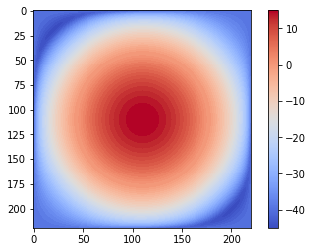

In [11]:
im = rgb2gray(imread('../images/lena.jpg'))
gauss_kernel = np.outer(signal.gaussian(im.shape[0], 1),
signal.gaussian(im.shape[1], 1))
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel))
pylab.imshow( (20*np.log10( 0.01 +
fp.fftshift(freq_kernel))).real.astype(int), cmap='coolwarm') # 0.01 is added to keep the argument to log function always positive
pylab.colorbar()
pylab.show()

### Frequency domain Gaussian blur filter with scipy signal.fftconvolve()

The following code block shows how the SciPy signal module's fftconvolve() function can be used to **run the convolution in the frequency domain** (internally by just a multiplication and the convolution theorem):

(224, 225)


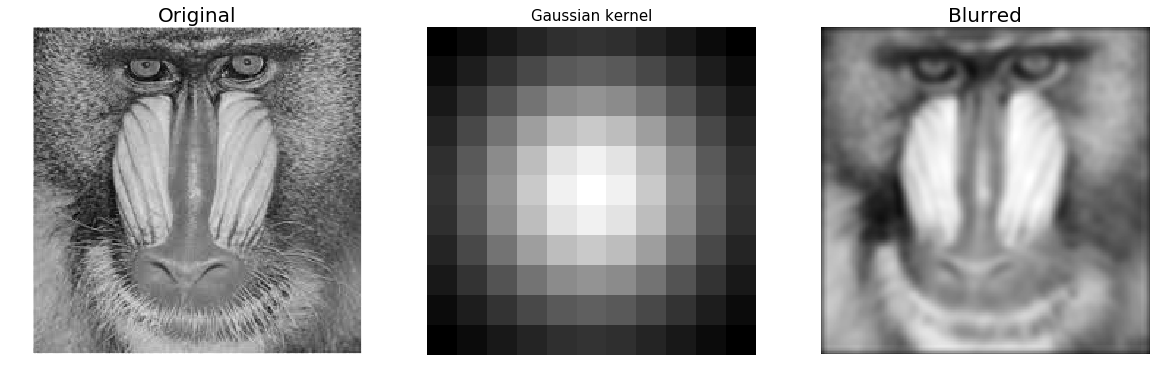

In [13]:
im = np.mean(misc.imread('../images/mandrill.jpg'), axis=2)
print(im.shape) # (224, 225)
gauss_kernel = np.outer(signal.gaussian(11, 3), signal.gaussian(11, 3)) # 2D Gaussian kernel of size 11x11 with σ = 3
im_blurred = signal.fftconvolve(im, gauss_kernel, mode='same')
fig, (ax_original, ax_kernel, ax_blurred) = pylab.subplots(1, 3, figsize=(20,8))
ax_original.imshow(im, cmap='gray')
ax_original.set_title('Original', size=20)
ax_original.set_axis_off()
ax_kernel.imshow(gauss_kernel)
ax_kernel.set_title('Gaussian kernel', size=15)
ax_kernel.set_axis_off()
ax_blurred.imshow(im_blurred, cmap='gray')
ax_blurred.set_title('Blurred', size=20)
ax_blurred.set_axis_off()
fig.show()

The following code block shows how to plot **the original and the blurred image spectrum **after convolution:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


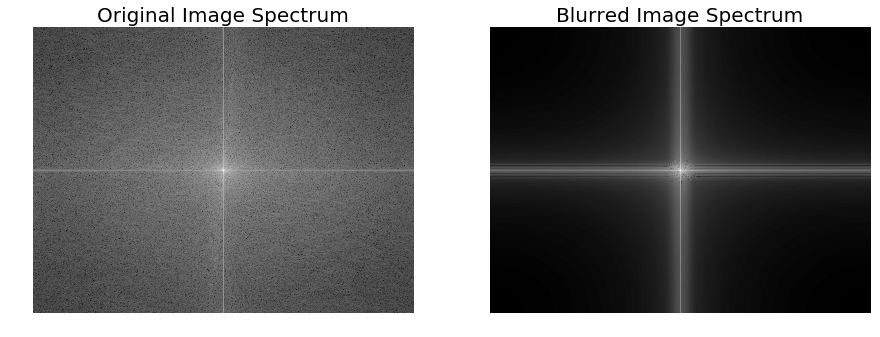

In [19]:
import scipy.fftpack as fftpack
F1 = fftpack.fft2((im).astype(float))
F2 = fftpack.fftshift( F1 )
pylab.figure(figsize=(15,8))
pylab.subplot(1,2,1), pylab.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=pylab.cm.gray)
pylab.title('Original Image Spectrum', size=20)
pylab.axis("off")
F1 = fftpack.fft2((im_blurred).astype(float))
F2 = fftpack.fftshift( F1 )
pylab.subplot(1,2,2), pylab.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=pylab.cm.gray)
pylab.title('Blurred Image Spectrum', size=20)
pylab.axis("off")
pylab.show()

The same code block as the previous one is used to compute a blurred version of the Victoria Memorial Hall image, but this time the fftconvolve() function is invoked with a larger (50 x 50) Gaussian kernel with σ=10. The following screenshot shows the output of the same code with the new image and the modified kernel

(540, 720)


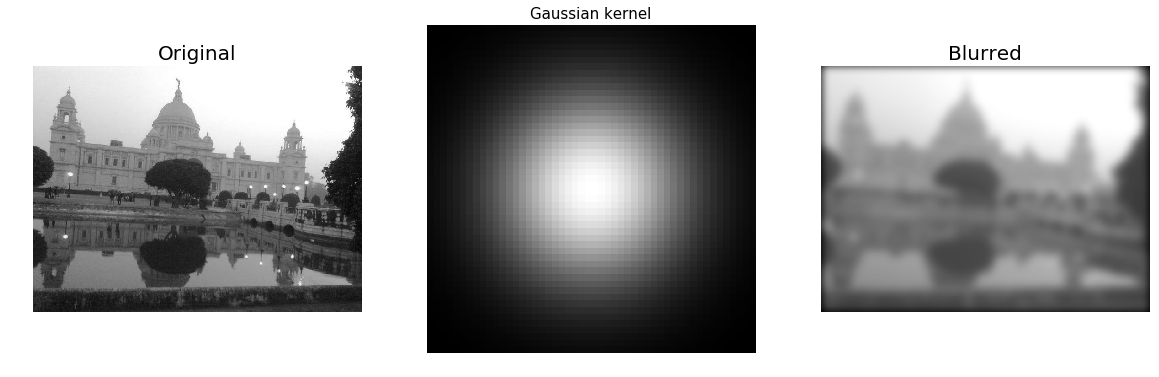

In [16]:
im = np.mean(misc.imread('../images/victoria_memorial.png'), axis=2)
print(im.shape) # (224, 225)
gauss_kernel = np.outer(signal.gaussian(50, 10), signal.gaussian(50, 10)) 
# 2D Gaussian kernel of size 11x11 with σ = 3
im_blurred = signal.fftconvolve(im, gauss_kernel, mode='same')
fig, (ax_original, ax_kernel, ax_blurred) = pylab.subplots(1, 3, figsize=(20,8))
ax_original.imshow(im, cmap='gray')
ax_original.set_title('Original', size=20)
ax_original.set_axis_off()
ax_kernel.imshow(gauss_kernel)
ax_kernel.set_title('Gaussian kernel', size=15)
ax_kernel.set_axis_off()
ax_blurred.imshow(im_blurred, cmap='gray')
ax_blurred.set_title('Blurred', size=20)
ax_blurred.set_axis_off()
fig.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


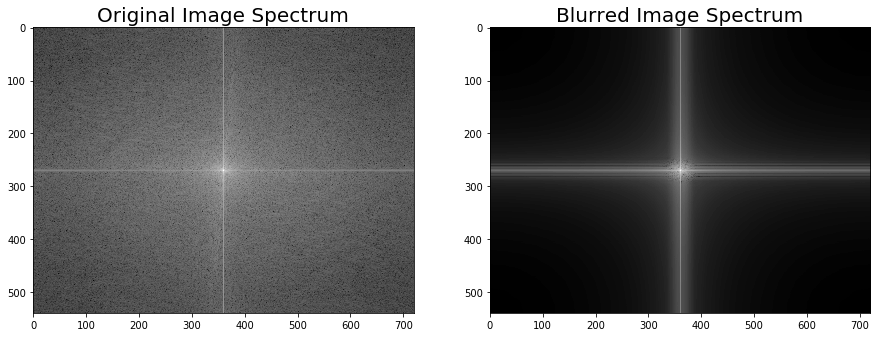

In [21]:
import scipy.fftpack as fftpack
F1 = fftpack.fft2((im).astype(float))
F2 = fftpack.fftshift( F1 )
pylab.figure(figsize=(15,8))
pylab.subplot(1,2,1), pylab.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=pylab.cm.gray)
pylab.title('Original Image Spectrum', size=20)
F1 = fftpack.fft2((im_blurred).astype(float))
F2 = fftpack.fftshift( F1 )
pylab.subplot(1,2,2), pylab.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=pylab.cm.gray)
pylab.title('Blurred Image Spectrum', size=20)
pylab.show()

### Comparing the runtimes of SciPy convolve() and fftconvolve() with the Gaussian blur kernel

We can use the Python <font face='cursive'>timeit</font> module to compare the **runtimes ** of the image domain and the frequency domain convolution functions. **Since the frequency domain convolution involves a single matrix multiplication instead of a series of sliding window arithmetic computations, it is expected to be much faster.** The following code compares the runtimes:

(224, 225)


/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


(<matplotlib.axes._subplots.AxesSubplot at 0x7f0acfd7ec88>,
 (-0.5, 224.5, 223.5, -0.5))

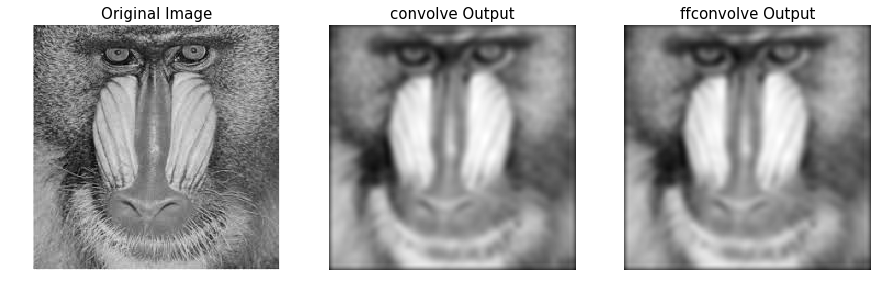

In [22]:
im = np.mean(misc.imread('../images/mandrill.jpg'), axis=2)
print(im.shape) # (224, 225)
gauss_kernel = np.outer(signal.gaussian(11, 3), signal.gaussian(11, 3)) 
# 2D Gaussian kernel of size 11x11 with σ = 3
im_blurred1 = signal.convolve(im, gauss_kernel, mode="same")
im_blurred2 = signal.fftconvolve(im, gauss_kernel, mode='same')
def wrapper_convolve(func):
    def wrapped_convolve():
        return func(im, gauss_kernel, mode="same")
    return wrapped_convolve
wrapped_convolve = wrapper_convolve(signal.convolve)
wrapped_fftconvolve = wrapper_convolve(signal.fftconvolve)
times1 = timeit.repeat(wrapped_convolve, number=1, repeat=100)
times2 = timeit.repeat(wrapped_fftconvolve, number=1, repeat=100)

#The following code block displays the original Mandrill image, as well as the blurred images, using both functions:
pylab.figure(figsize=(15,5))
pylab.gray()
pylab.subplot(131), pylab.imshow(im), pylab.title('Original Image',size=15), pylab.axis('off')
pylab.subplot(132), pylab.imshow(im_blurred1), pylab.title('convolve Output', size=15), pylab.axis('off')
pylab.subplot(133), pylab.imshow(im_blurred2), pylab.title('ffconvolve Output', size=15),pylab.axis('off')

#As expected, both the convolve() and fftconvolve() functions result in the same blurred output image:

The following code visualizes the difference in between runtimes. Each of the functions has been run on the same input image with the same Gaussian kernel 100 times and then the boxplot of the times taken for each function is plotted:

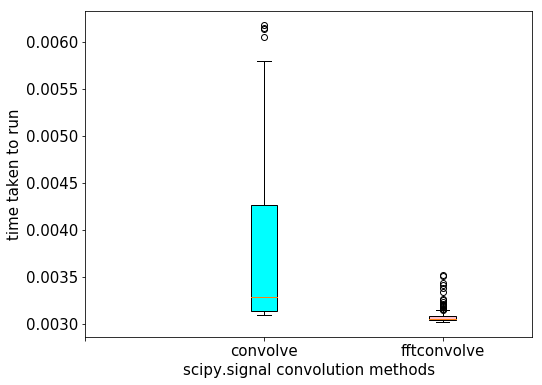

In [23]:
data = [times1, times2]
pylab.figure(figsize=(8,6))
box = pylab.boxplot(data, patch_artist=True) #notch=True,
colors = ['cyan', 'pink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
pylab.xticks(np.arange(3), ('', 'convolve', 'fftconvolve'), size=15)
pylab.yticks(fontsize=15)
pylab.xlabel('scipy.signal convolution methods', size=15)
pylab.ylabel('time taken to run', size = 15)
pylab.show()

# The following screenshot shows the output of the preceding code. 
# As can be seen, fftconvolve() runs faster on average:

### Filtering in the frequency domain (HPF, LPF, BPF, and notch filters)
<p>If we remember from the image processing pipeline described in Chapter 1, Getting Started with Image Processing, the immediate next step after image acquisition is image pre-processing. Images are often **corrupted by random variations in intensity and illumination or have poor contrast**, and therefore can't be used directly and need to be enhanced. This is where the filters are used.</p>

**What is a filter?**
* Filtering refers to transforming pixel intensity values to reveal certain image characteristics such as:
    1. **Enhancement**: This image characteristic improves contrast
    2. **Smoothing**: This image characteristic removes noise
    3. **Template matching**: This image characteristic detects known patterns    
* The filtered image is described by a discrete convolution and the filter is described by a n x n discrete convolution mask.


#### High-Pass Filter (HPF)
This filter allows ***only high frequencies*** from the frequency domain representation of the image (obtained with DFT) and **blocks all low frequencies** beyond a cut-off value. The image is reconstructed with ***inverse DFT**, and since the ***high-frequency components correspond to edges, details, noise, and so on***, HPFs tend to **extract** or **enhance** them. The next few sections demonstrate **how to use different functions from the<span style="color:red"> numpy, scipy, and scikit-image</span> libraries** to implement an HPF and the impact of an HPF on an image.
* We can implement a HPF on an image with the following steps:
    1. Perform a 2D FFT with scipy.fftpack fft2 and obtain the frequency domain representation of the image
    2. Keep only the high frequency components (get rid of the low frequency components)
    3. Perform an inverse FFT to reconstruct the image

The Python code to implement an HPF is shown in the following code. As can be seen, _the high frequency components correspond more to the edges of an image, and the average (flat) image information is lost as we get rid of more and more low frequency components:_
[Mode in PIL, image.convert('RGB')](https://stackoverflow.com/questions/52307290/what-is-the-difference-between-images-in-p-and-l-mode-in-pil/52307690)

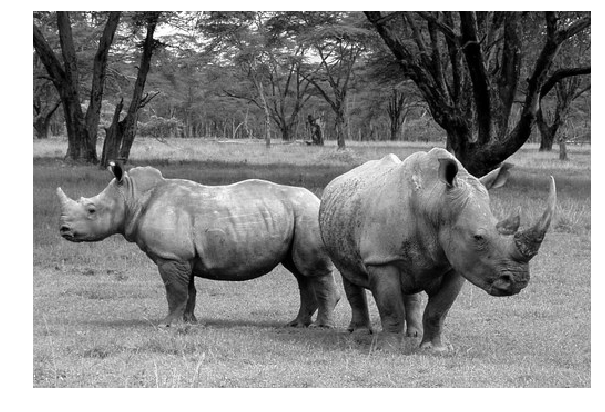

In [25]:
#a=Image.open('../images/rhino.jpg')

im = np.array(Image.open('../images/rhino.jpg').convert('L')) 
pylab.figure(figsize=(10,10))
pylab.imshow(im, cmap=pylab.cm.gray)
pylab.axis('off')
pylab.show()

plot the original rhino image spectrum in the logarithm domain, as well, show the original rhino image spectrum on following screen

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


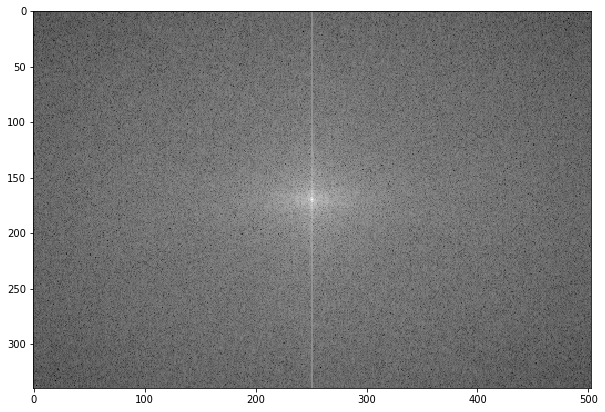

In [30]:
freq = fp.fft2(im)
(w, h) = freq.shape
half_w, half_h = int(w/2), int(h/2)
freq1 = np.copy(freq)
freq2 = fp.fftshift(freq1)
pylab.figure(figsize=(10,10))
pylab.imshow( (20*np.log10( 0.1 + freq2)).astype(int))
pylab.show()

The following screenshot shows the spectrum of the rhino image after applying the HPF,the output of the previous code:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


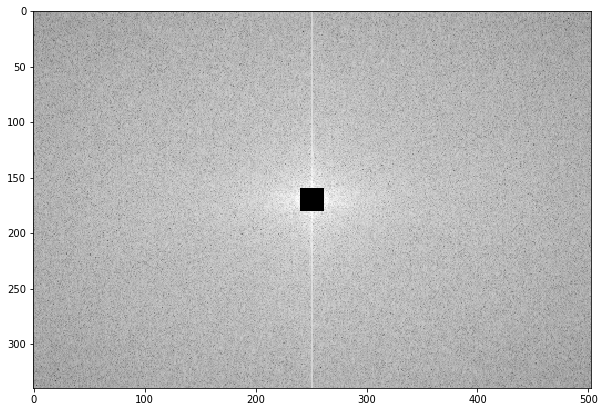

In [28]:
freq2[half_w-10:half_w+11,half_h-10:half_h+11] = 0 # select all but the first 20x20 (low) frequencies
pylab.figure(figsize=(10,10))
pylab.imshow( (20*np.log10( 0.1 + freq2)).astype(int))
pylab.show()

The following code block shows how to obtain the image back from the previous spectrum by applying **ifft2()**:

2.023722773801701


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `signaltonoise` is deprecated!
scipy.stats.signaltonoise is deprecated in scipy 0.16.0
  


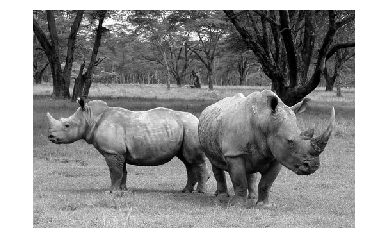

In [32]:
im1 = np.clip(fp.ifft2(fftpack.ifftshift(freq2)).real,0,255) # clip pixel values after IFFT
print(signaltonoise(im1, axis=None))
# 0.5901647786775175
pylab.imshow(im1, cmap='gray')
pylab.axis('off')
pylab.show()

The screenshot above shows the output of the preceding code: the rhino image after the HPF is applied. As can be seen, the edges in **the image become more prominent—HPF finds the edges** (which correspond to higher frequencies) in the image:

The following code block shows the application of the HPF on the cameraman grayscale image, **with different frequency cut-off values, F:**

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `signaltonoise` is deprecated!
scipy.stats.signaltonoise is deprecated in scipy 0.16.0
  


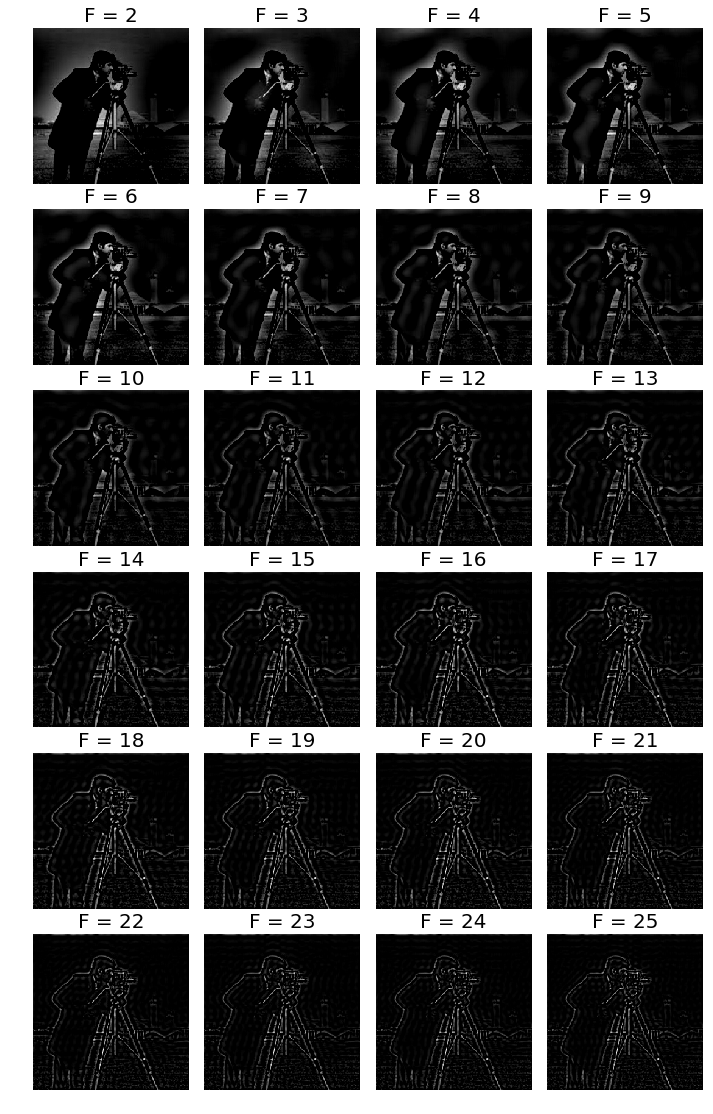

In [33]:
from scipy import fftpack
im = np.array(Image.open('../images/cameraman.jpg').convert('L'))
freq = fp.fft2(im)
(w, h) = freq.shape
half_w, half_h = int(w/2), int(h/2)
snrs_hp = []
lbs = list(range(1,25))
pylab.figure(figsize=(12,20))
for l in lbs:
    freq1 = np.copy(freq)
    freq2 = fftpack.fftshift(freq1)
    freq2[half_w-l:half_w+l+1,half_h-l:half_h+l+1] = 0 # select all but the first lxl (low) frequencies
    im1 = np.clip(fp.ifft2(fftpack.ifftshift(freq2)).real,0,255) # clip pixel values after IFFT
    snrs_hp.append(signaltonoise(im1, axis=None))
    pylab.subplot(6,4,l), pylab.imshow(im1, cmap='gray'), pylab.axis('off')
    pylab.title('F = ' + str(l+1), size=20)
pylab.subplots_adjust(wspace=0.1, hspace=0)
pylab.show()

### How SNR changes with frequency cut-off

The following code block shows how to plot the change in the signal to noise ratio (SNR) with the cutoff frequency (F) for the HPF:

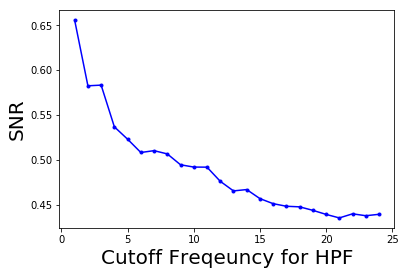

In [34]:
pylab.plot(lbs, snrs_hp, 'b.-')
pylab.xlabel('Cutoff Freqeuncy for HPF', size=20)
pylab.ylabel('SNR', size=20)
pylab.show()

# The following screenshot shows how the SNR of the output image decreases with the increase 
# in the cutoff frequency of the HPF:

### Low-pass filter (LPF)

This filter allows only the low frequencies from the frequency domain representation of the image (obtained with DFT), and blocks all high frequencies beyond a cut-off value. The image is reconstructed with inverse DFT, and since the high-frequency components correspond to edges, details, noise, and so on, LPF tends to remove these. The next few sections demonstrate how to use different functions from the _***numpy, scipy, and scikit-image***_ libraries to implement an LPF and the impact of an LPF on an image.

The next code block demonstrates how to use the LPF (weighted average filter) to blur the _***lena***_ grayscale image:


#### LPF with fourier_gaussian

This function from the scipy _***ndimage***_ module implements **a multi-dimensional Gaussian Fourier filter**. The frequency array is multiplied with the Fourier transform of a Gaussian kernel of a given size.


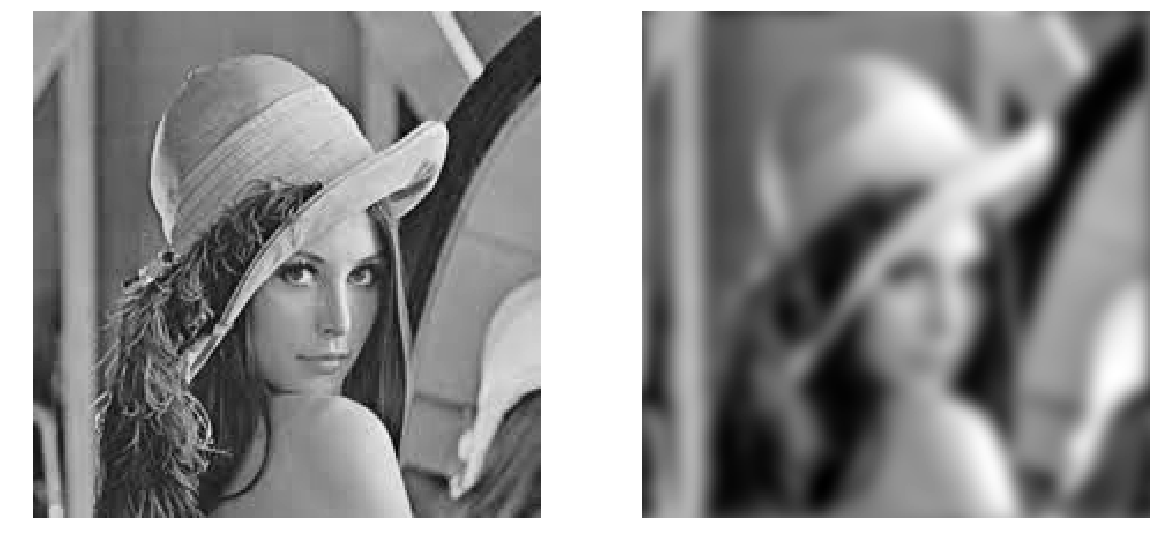

In [35]:
import numpy.fft as fp
fig, (axes1, axes2) = pylab.subplots(1, 2, figsize=(20,10))
pylab.gray() # show the result in grayscale
im = np.mean(imread('../images/lena.jpg'), axis=2)
freq = fp.fft2(im)
freq_gaussian = ndimage.fourier_gaussian(freq, sigma=4)
im1 = fp.ifft2(freq_gaussian)
axes1.imshow(im), axes1.axis('off'), axes2.imshow(im1.real) # the imaginary part is an artifact
axes2.axis('off')
pylab.show()

# After execution, The following screenshot shows the output of the preceding code block:

The preceding code block displays the frequency spectrum of the image after the box kernel is applied:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


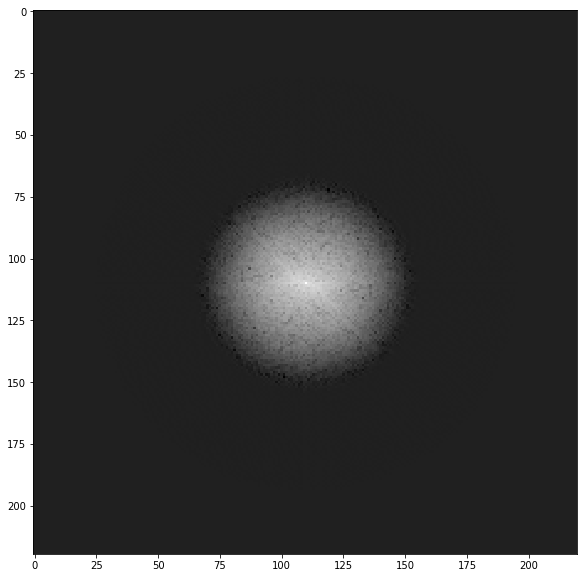

In [36]:
pylab.figure(figsize=(10,10))
pylab.imshow( (20*np.log10( 0.1 +
numpy.fft.fftshift(freq_gaussian))).astype(int))
pylab.show()

#The following screenshot shows the output of the preceding code block 
# and displays the frequency spectrum of the image after the Gaussian kernel is applied:

#### LPF with scipy fftpack

We can implement a LPF on an image with the following steps:
1. Perform a 2D FFT with scipy.fftpack fft2 and obtain the frequency domain representation of the image
2. Keep only the low frequency components (get rid of the high frequency components)
3. Perform an inverse FFT to reconstruct the image 

The Python code to implement an LPF is shown in the following code. As can be seen from the next screenshots, the high frequency components correspond more to the average (flat) image information and the detailed information (for example, the edges) of an image is lost as we get rid of more and more high-frequency components.

For example, if we keep only the first-frequency component and discard all others, in the resulting image obtained after inverse FFT we can hardly see the rhinos, but as we keep more and more higher frequencies, they become prominent in the final image:

2.389151856495428


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `signaltonoise` is deprecated!
scipy.stats.signaltonoise is deprecated in scipy 0.16.0
  del sys.path[0]


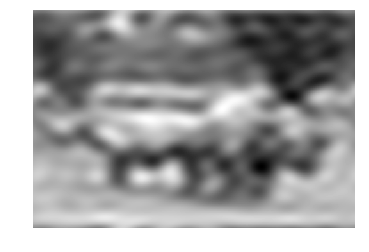

In [37]:
from scipy import fftpack
im = np.array(Image.open('../images/rhino.jpg').convert('L'))
# low pass filter
freq = fp.fft2(im)
(w, h) = freq.shape
half_w, half_h = int(w/2), int(h/2)
freq1 = np.copy(freq)
freq2 = fftpack.fftshift(freq1)
freq2_low = np.copy(freq2)
freq2_low[half_w-10:half_w+11,half_h-10:half_h+11] = 0 # block the lowfrequencies
freq2 -= freq2_low # select only the first 20x20 (low) frequencies, block the high frequencies
im1 = fp.ifft2(fftpack.ifftshift(freq2)).real
print(signaltonoise(im1, axis=None))
# 2.389151856495427
pylab.imshow(im1, cmap='gray'), pylab.axis('off')
pylab.show()

# The following screenshot shows the output of the preceding code, 
# the gross output image obtained without the finer details by applying LPF on the input rhino image:

The following code block shows how to plot the spectrum of the image in the logarithm domain after blocking the high frequencies; in other words, only allowing the low frequencies:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


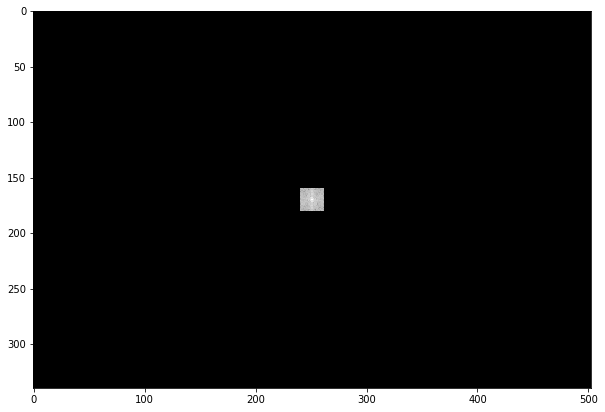

In [38]:
pylab.figure(figsize=(10,10))
pylab.imshow( (20*np.log10( 0.1 + freq2)).astype(int))
pylab.show()

The following code block shows the application of LPF on the cameraman grayscale image, with different frequency cutoff values, F:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `signaltonoise` is deprecated!
scipy.stats.signaltonoise is deprecated in scipy 0.16.0
  from ipykernel import kernelapp as app


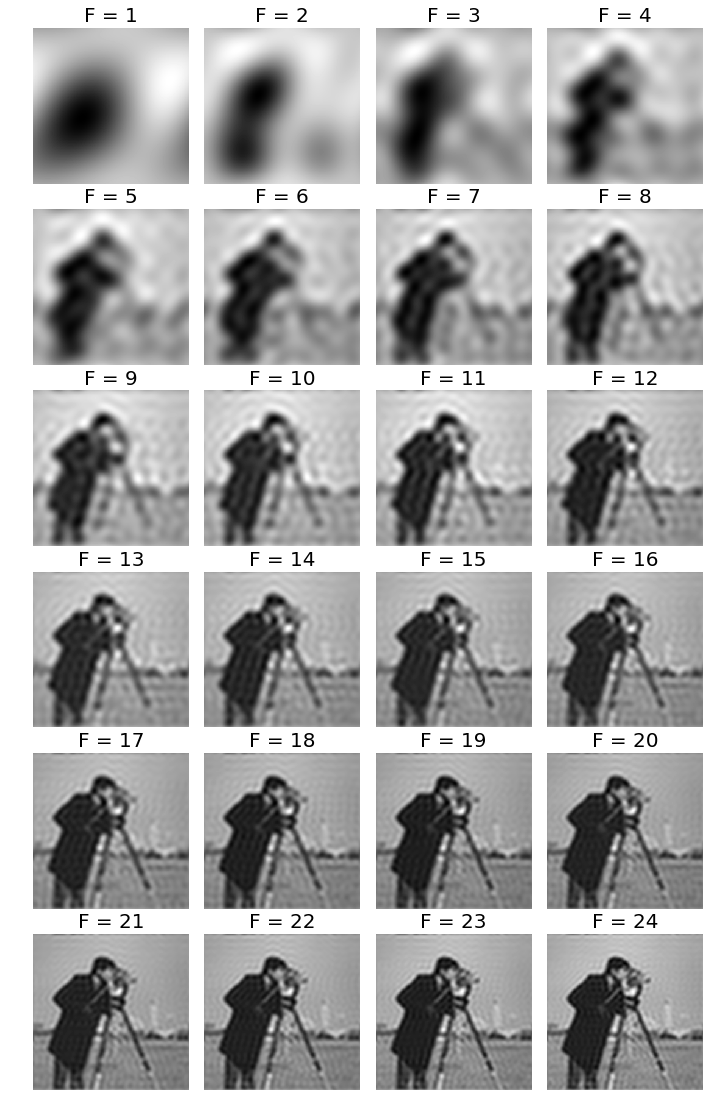

In [39]:
im = np.array(Image.open('../images/cameraman.jpg').convert('L'))
freq = fp.fft2(im)
(w, h) = freq.shape
half_w, half_h = int(w/2), int(h/2)
snrs_lp = []
ubs = list(range(1,25))
pylab.figure(figsize=(12,20))
for u in ubs:
    freq1 = np.copy(freq)
    freq2 = fftpack.fftshift(freq1)
    freq2_low = np.copy(freq2)
    freq2_low[half_w-u:half_w+u+1,half_h-u:half_h+u+1] = 0
    freq2 -= freq2_low # select only the first 20x20 (low) frequencies
    im1 = fp.ifft2(fftpack.ifftshift(freq2)).real
    snrs_lp.append(signaltonoise(im1, axis=None))
    pylab.subplot(6,4,u), pylab.imshow(im1, cmap='gray'), pylab.axis('off')
    pylab.title('F = ' + str(u), size=20)
pylab.subplots_adjust(wspace=0.1, hspace=0)
pylab.show()

# The following screenshot shows how LPF detects more and more details in the image as the cutoff frequency, F, 
# increases:

### How SNR changes with frequency cutoff
The following code block shows how to plot the change in signal to noise ratio (SNR) with cutoff frequency (F) for LPF:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `signaltonoise` is deprecated!
scipy.stats.signaltonoise is deprecated in scipy 0.16.0
  """Entry point for launching an IPython kernel.


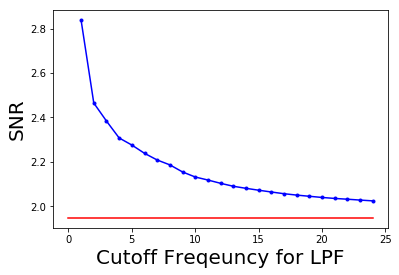

In [40]:
snr = signaltonoise(im, axis=None)
pylab.plot(ubs, snrs_lp, 'b.-')
pylab.plot(range(25), [snr]*25, 'r-')
pylab.xlabel('Cutoff Freqeuncy for LPF', size=20)
pylab.ylabel('SNR', size=20)
pylab.show()

The picture above shows how SNR of the output image decreases with the increase in the cut-off frequency of LPF. The red horizontal line indicates the original image's SNR, plotted for comparison

### Band-pass filter (BPF) with DoG

The _***Difference of Gaussian (DoG)***_ kernel can be used as a BPF to allow the frequencies in a certain band and discard all other frequencies. The following code block shows how the DoG kernel can be used with fftconvolve() to implement a BPF:


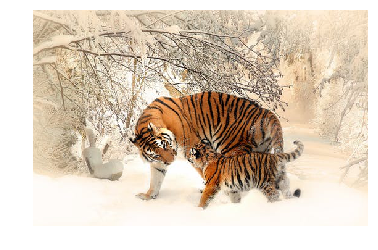

0.7862192363545747


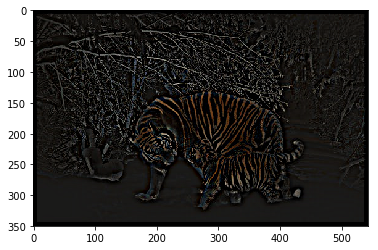

In [41]:
from skimage import img_as_float
im = img_as_float(pylab.imread('../images/tigers.jpeg'))
pylab.figure(), pylab.imshow(im), pylab.axis('off'), pylab.show()
x = np.linspace(-10, 10, 15)
kernel_1d = np.exp(-0.005*x**2)
kernel_1d /= np.trapz(kernel_1d) # normalize the sum to 1
gauss_kernel1 = kernel_1d[:, np.newaxis] * kernel_1d[np.newaxis, :]
kernel_1d = np.exp(-5*x**2)
kernel_1d /= np.trapz(kernel_1d) # normalize the sum to 1
gauss_kernel2 = kernel_1d[:, np.newaxis] * kernel_1d[np.newaxis, :]
DoGKernel = gauss_kernel1[:, :, np.newaxis] - gauss_kernel2[:, :, np.newaxis]
im = signal.fftconvolve(im, DoGKernel, mode='same')
pylab.figure(), pylab.imshow(np.clip(im, 0, 1)), print(np.max(im)),
pylab.show()

#The following screenshot shows the output of the preceding code block, the output image obtained with the BPF:

### Band-stop (notch) filter 

This filter blocks/rejects a few chosen frequencies from the frequency domain representation of the image (obtained with DFT), and hence the name. It is useful for removing periodic noise from images, as discussed in the next section.

### Using a notch filter to remove periodic noise from images

In this example, we will first add some periodic (sinusoidal) noise to the parrot image to create a noisy parrot image (this can happen because of interference with some electrical signal) and then observe the effect of the noise in the frequency domain of the image using the following code block:

(340, 453)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


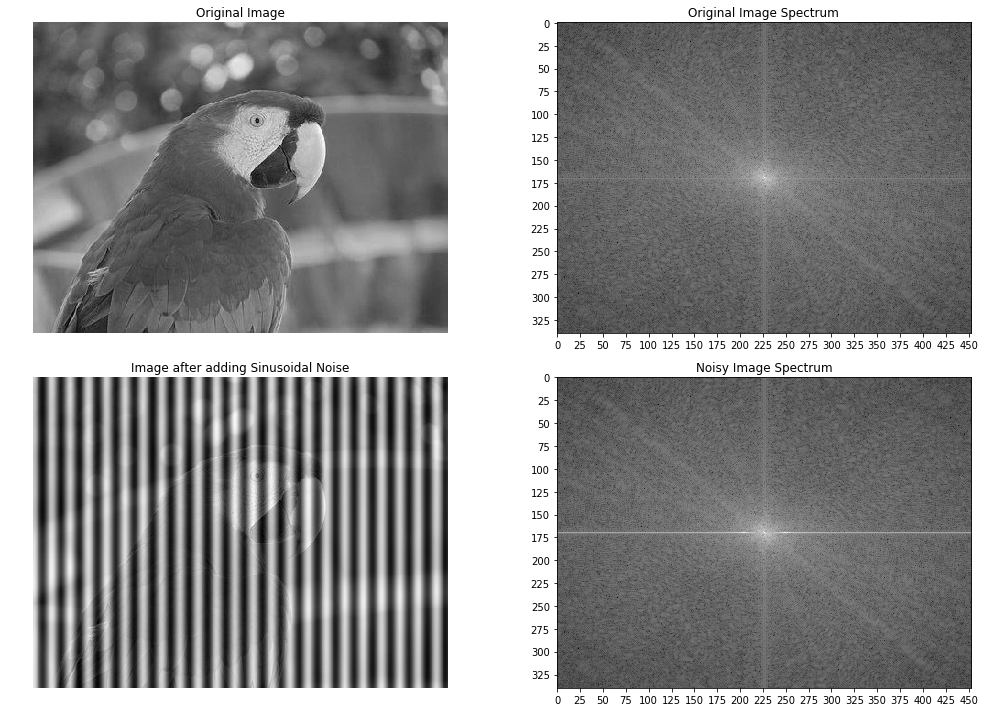

In [42]:
from scipy import fftpack
pylab.figure(figsize=(15,10))
im =  np.mean(imread("../images/parrot.png"), axis=2) / 255
print(im.shape)
pylab.subplot(2,2,1), pylab.imshow(im, cmap='gray'), pylab.axis('off')
pylab.title('Original Image')
F1 = fftpack.fft2((im).astype(float))
F2 = fftpack.fftshift( F1 )
pylab.subplot(2,2,2), pylab.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=pylab.cm.gray)
pylab.xticks(np.arange(0, im.shape[1], 25))
pylab.yticks(np.arange(0, im.shape[0], 25))
pylab.title('Original Image Spectrum')
# add periodic noise to the image
for n in range(im.shape[1]):
    im[:, n] += np.cos(0.1*np.pi*n)
pylab.subplot(2,2,3), pylab.imshow(im, cmap='gray'), pylab.axis('off')
pylab.title('Image after adding Sinusoidal Noise')
F1 = fftpack.fft2((im).astype(float)) # noisy spectrum
F2 = fftpack.fftshift( F1 )
pylab.subplot(2,2,4), pylab.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=pylab.cm.gray)
pylab.xticks(np.arange(0, im.shape[1], 25))
pylab.yticks(np.arange(0, im.shape[0], 25))
pylab.title('Noisy Image Spectrum')
pylab.tight_layout()
pylab.show()

# The following screenshot shows the output of the preceding code block. 
# As can be seen, the periodic noise there on the horizontal line became more prominent
# in the frequency spectrum around u = 175:

Now let's design a band-stop/band-reject (notch) filter to eliminate the frequencies that are responsible for noise by setting the corresponding frequency components to zero in the next code block:

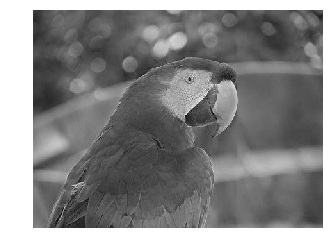

In [44]:
F2[170:176,:220] = F2[170:176,230:] = 0 # eliminate the frequencies most likely responsible for noise (keep some low frequency components)
im1 = fftpack.ifft2(fftpack.ifftshift( F2 )).real
pylab.axis('off')
pylab.imshow(im1, cmap='gray')
pylab.show()

The screenshot shows the output of the preceding code block, the restored image by applying the notch filter. As can be seen, the original image looks sharper than the restored one, since some true frequencies from the original image are also rejected by the band-reject filter along with the noise.

### Image restoration

<p>In image restoration, the degradation is modeled. This enables the effects of the degradation to be (largely) removed. The challenge is the loss of information and noise. The following diagram shows the basic image degradation model: </p>
<img src="../images/ch-3-4.png" >

<p>In the next few sections, we will describe a couple of degradation models (namely _***inverse***_ and Wiener filters).</p>


### Deconvolution and inverse filtering with FFT

Given a blurred image **with a known (assumed) blur kernel**, a typical image processing task is to **get back (at least an approximation of) the original image**. This particular task is known as _***deconvolution***_. One of the naive filters that can be applied in the frequency domain to achieve this is the inverse filter that we are going to discuss in this section. 

Let's first **start by blurring the grayscale** _***lena***_ image with **Gaussian blur **using the following code:

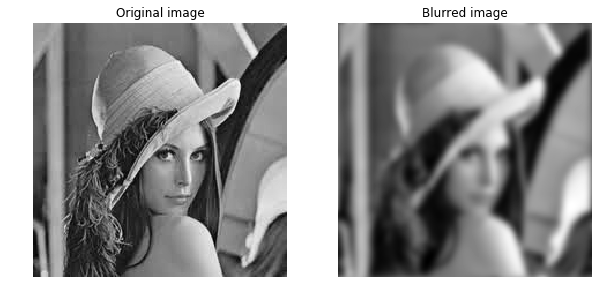

In [45]:
im = 255*rgb2gray(imread('../images/lena.jpg'))
gauss_kernel = np.outer(signal.gaussian(im.shape[0], 3),
signal.gaussian(im.shape[1], 3))
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel)) # this is our H
convolved = freq*freq_kernel # by convolution theorem
im_blur = fp.ifft2(convolved).real
im_blur = 255 * im_blur / np.max(im_blur) # normalize

pylab.figure(figsize=(10,10))
pylab.gray()
pylab.subplot(121), pylab.imshow(im), pylab.title('Original image'), pylab.axis('off')
pylab.subplot(122), pylab.imshow(im_blur), pylab.title('Blurred image'), pylab.axis('off')
pylab.show()

Now we can use the inverse filter on the blurred image (using the same H) to get back the original image. The following code block demonstrates how to do it:

243.7587 255.0


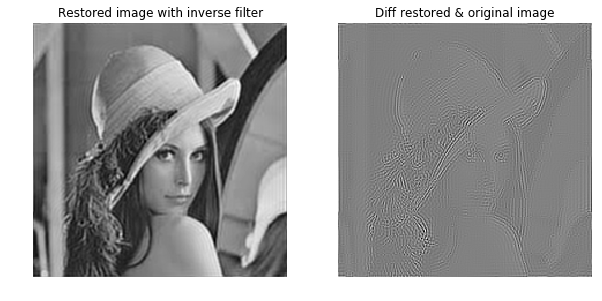

In [46]:
epsilon = 10**-6
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel) # avoid division by zero
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = 255 * im_restored / np.max(im_restored)
print(np.max(im), np.max(im_restored))
pylab.figure(figsize=(10,10))
pylab.gray()
#pylab.subplot(221), pylab.imshow(im), pylab.title('Original image'), pylab.axis('off')
#pylab.subplot(222), pylab.imshow(im_blur), pylab.title('Blurred image'), pylab.axis('off')
pylab.subplot(121), pylab.imshow(im_restored), pylab.title('Restored image with inverse filter'), pylab.axis('off')
pylab.subplot(122), pylab.imshow(im_restored - im), pylab.title('Diff restored & original image'), pylab.axis('off')
pylab.show()

#As can be seen, although the inverse filter deblurs the blurred image, there is some loss of information

Please refer textbook for an advanced discussion, exercise and question 4 in the _**Question**_ section.

**Skip next example for motion deblur**

Similarly, we can deblur an image blurred with a known **motion blur kernel** using the inverse filter. The code remains the same; **only the kernel changes, as shown in the following code**. Note that we need to create **a zero-padded kernel** of a size equal to the size of the original image before we can apply the convolution in the frequency domain (using np.pad(); the details are left as an exercise for you):

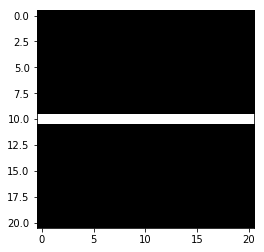

In [48]:
kernel_size = 21 # a 21 x 21 motion blurred kernel
mblur_kernel = np.zeros((kernel_size, kernel_size))
mblur_kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
mblur_kernel = mblur_kernel / kernel_size
pylab.imshow(mblur_kernel)

In [49]:
### this is code, refer textbook
im = 255*rgb2gray(imread('../images/lena.jpg'))
gauss_kernel = np.outer(signal.gaussian(im.shape[0], 3),
signal.gaussian(im.shape[1], 3))
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel)) # this is our H

freq_kernel= mblur_kernel

convolved = freq*freq_kernel # by convolution theorem
im_blur = fp.ifft2(convolved).real
im_blur = 255 * im_blur / np.max(im_blur) # normalize

pylab.figure(figsize=(10,10))
pylab.gray()
pylab.subplot(121), pylab.imshow(im), pylab.title('Original image'), pylab.axis('off')
pylab.subplot(122), pylab.imshow(im_blur), pylab.title('Blurred image'), pylab.axis('off')
pylab.show()

ValueError: operands could not be broadcast together with shapes (220,220) (21,21) 

In [50]:
### this is code, refer textbook
epsilon = 10**-6
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel) # avoid division by zero
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = 255 * im_restored / np.max(im_restored)
print(np.max(im), np.max(im_restored))
pylab.figure(figsize=(10,10))
pylab.gray()
#pylab.subplot(221), pylab.imshow(im), pylab.title('Original image'), pylab.axis('off')
#pylab.subplot(222), pylab.imshow(im_blur), pylab.title('Blurred image'), pylab.axis('off')
pylab.subplot(121), pylab.imshow(im_restored), pylab.title('Restored image with inverse filter'), pylab.axis('off')
pylab.subplot(122), pylab.imshow(im_restored - im), pylab.title('Diff restored & original image'), pylab.axis('off')
pylab.show()

#As can be seen, although the inverse filter deblurs the blurred image, there is some loss of information

ValueError: operands could not be broadcast together with shapes (220,220) (21,21) 

### Image deconvolution with the Wiener filter

We already saw how to to obtain the (approximate) original image from the blurred image (with a known blur kernel) using the inverse filter in the last section. Another important task in image processing is the ***removal of noise from a _corrupted_ signal.*** This is also known as image restoration. The following code block shows how the **scikit-image restoration** module's ***unsupervised Wiener filter*** can be used for image denoising with deconvolution:

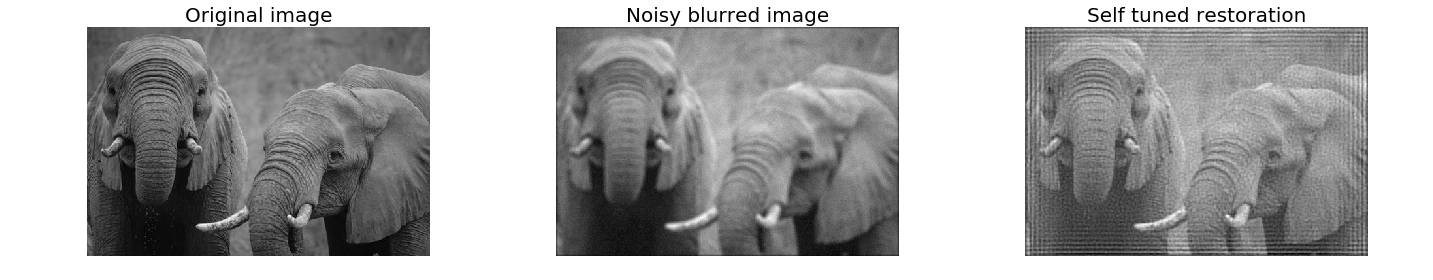

In [51]:
from skimage import color, data, restoration
im = color.rgb2gray(imread('../images/elephant_g.jpg'))
from scipy.signal import convolve2d as conv2
n = 7
psf = np.ones((n, n)) / n**2
im1 = conv2(im, psf, 'same')
im1 += 0.1 * im1.std() * np.random.standard_normal(im1.shape)
im2, _ = restoration.unsupervised_wiener(im1, psf)
fig, axes = pylab.subplots(nrows=1, ncols=3, figsize=(20, 4), sharex=True, sharey=True)
pylab.gray()
axes[0].imshow(im), axes[0].axis('off'), axes[0].set_title('Original image', size=20)
axes[1].imshow(im1), axes[1].axis('off'), axes[1].set_title('Noisy blurred image', size=20)
axes[2].imshow(im2), axes[2].axis('off'), axes[2].set_title('Self tuned restoration', size=20)
fig.tight_layout()
pylab.show()

The screenshot shows the output of the previous code—the original, blurred-noisy, and restored image using the unsupervised Wiener filter

### Image denoising with FFT
The next example is taken from [plot_fft_image_denoise](http://www.scipy-lectures.org/intro/scipy/auto_examples/solutions/plot_fft_image_denoise.html). This example demonstrates how to denoise an image first by blocking Fourier elements with high frequencies using a LPF with FFT. Let's first display the noisy grayscale image with the following code block:

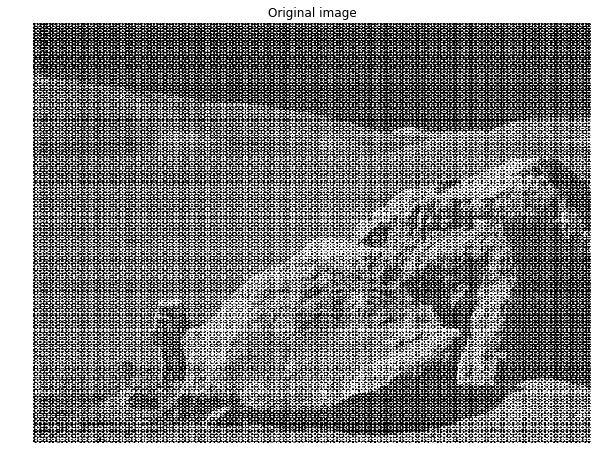

(<matplotlib.image.AxesImage at 0x7f0acd075cc0>,
 (-0.5, 629.5, 473.5, -0.5),
 None)

In [52]:
im = pylab.imread('../images/moonlanding.png').astype(float)
pylab.figure(figsize=(10,10))
pylab.imshow(im, pylab.cm.gray), pylab.axis('off'), pylab.title('Original image'), pylab.show()

The screenshot shows the output of the preceding code block, the original noisy image

The following code block displays the frequency spectrum of the noisy image:

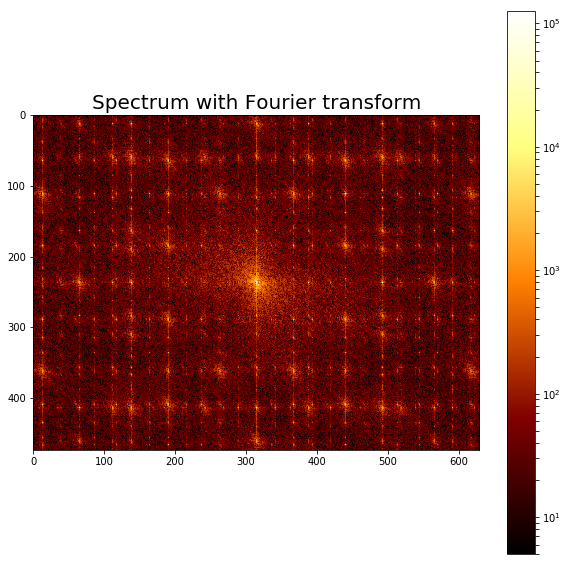

In [53]:
from scipy import fftpack
from matplotlib.colors import LogNorm
im_fft = fftpack.fft2(im)
def plot_spectrum(im_fft):
    pylab.figure(figsize=(10,10))
    pylab.imshow(np.abs(im_fft), norm=LogNorm(vmin=5), cmap=pylab.cm.afmhot), pylab.colorbar()
pylab.figure(), plot_spectrum(fftpack.fftshift(im_fft))
pylab.title('Spectrum with Fourier transform', size=20)

The screenshot shows the output of the preceding code, the Fourier spectrum of the original noisy image.

### Filter in FFT
The following code block shows how to reject a bunch of high frequencies and implement an LPF to attenuate noise (which corresponds to high-frequency components) from the image:

(<matplotlib.figure.Figure at 0x7f0accc62908>,
 None,
 <matplotlib.text.Text at 0x7f0acc7cd208>)

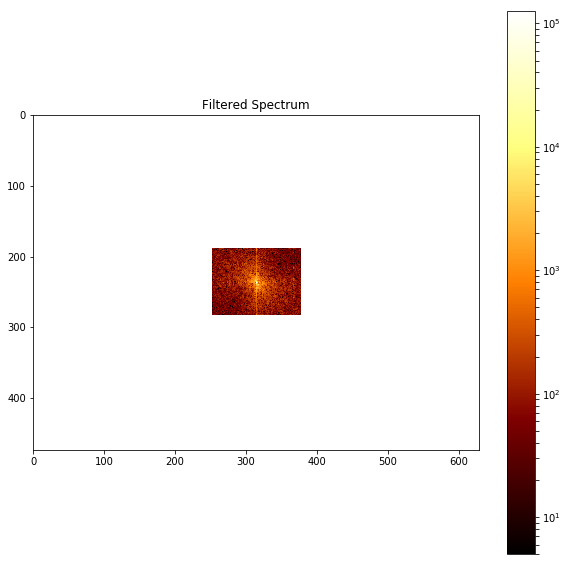

In [55]:
# Copy the original spectrum and truncate coefficients.
# Define the fraction of coefficients (in each direction) to keep as
keep_fraction = 0.1
im_fft2 = im_fft.copy()
# Set r and c to the number of rows and columns of the array.
r, c = im_fft2.shape
# Set all rows to zero with indices between r*keep_fraction and r*(1-keep_fraction)
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
# Similarly with the columns
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
pylab.figure(), plot_spectrum(fftpack.fftshift(im_fft2)),pylab.title('Filtered Spectrum')

The above screenshot shows the output of the preceding code, the filtered spectrum with the LPF.

### Reconstructing the final image

The following code block shows how to reconstruct the image with IFFT from the filtered Fourier coefficients:

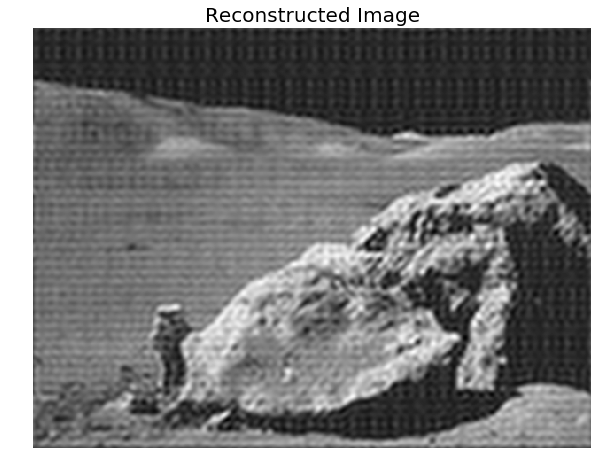

In [56]:
# Reconstruct the denoised image from the filtered spectrum, keep only the real part for display.
im_new = fp.ifft2(im_fft2).real
pylab.figure(figsize=(10,10)), pylab.imshow(im_new, pylab.cm.gray),
pylab.axis('off')
pylab.title('Reconstructed Image', size=20)

The above screenshot shows the output of the preceding code—a much cleaner output image obtained from the original noisy image with filtering in the frequency domain

### Summary

In this chapter, we discussed a few important concepts primarily related to ***2D convolution*** and its related applications in image processing, such as filtering in the spatial domain. We also discussed a few different frequency domain filtering techniques and illustrated them with quite a few examples with the _***scikit-image numpy fft, scipy, fftpack, signal, and ndimage***_ modules. We started with the ***convolution theorem*** and its application in ***frequency domain filtering, various frequency domain filters such as LPF, HPF, and notch filters, and finally deconvolution and its application in designing filters for image restoration, such as inverse and Wiener filters.***

On completion of this chapter, the reader should be able to write Python code to do 2D convolution/filtering, and should also be able to write Python code to implement time/frequency domain filters with/without convolution.

In the next chapter, we will start on different image enhancement techniques based on the concepts introduced in **the last two chapters**.

### Further reading

1. https://www.cs.cornell.edu/courses/cs1114/2013sp/sections/S06_convolution.pdf
2. http://www.aip.de/groups/soe/local/numres/bookcpdf/c13-3.pdf
3. http://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter4.pdf
4. https://web.stanford.edu/class/ee367/slides/lecture6.pdf
5. https://pdfs.semanticscholar.org/presentation/50e8/fb095faf6ed51e03c85a2fcb7eb1ae1b1009.pdf
6. http://www.robots.ox.ac.uk/~az/lectures/ia/lect2.pdf